# HarvestStat Data Profiling - Niger

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32631' # Niger
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/NE_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Niger',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

###################################################
# The current submitted data has an issue on start_date. Here we manually correct it.
idx = df['start_date'].apply(lambda x: x[-5:]) == '10-01'
df.loc[idx, 'start_date'] = df.loc[idx, 'start_date'].apply(lambda x: x[:-5] + '12-01')
###################################################

###################################################
# The latest data includes admin3 level data. We will include this later.
df['admin_level'] = df['fnid'].apply(lambda x: x[6:8])
df = df[df['admin_level'] != 'A3']
###################################################

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1972	 | NE1972A1 | 7	| NE1972A2	| 35	| nan	| 0	|
| 1992	 | NE1992A1 | 8	| NE1992A2	| 36	| nan	| 0	|
| 2001	 | NE2001A1 | 8	| NE2001A2	| 37	| nan	| 0	|
| 2012	 | NE2012A1 | 8	| NE2012A2	| 74	| nan	| 0	|
| 2018	 | NE2018A1 | 8	| NE2018A2	| 67	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Shape file correction
# Correct the 2012 admin file for Nigeria to include Agadez Commune
NE_Admin2_2012.loc[NE_Admin2_2012.FNID=='NE2012A20109','ADMIN2'] = 'Agadez Commune'
NE_Admin2_2012.loc[NE_Admin2_2012.FNID=='NE2012A20109','ADMIN2FR'] = 'Agadez Commune'
NE_Admin2_2012.loc[NE_Admin2_2012.FNID=='NE2012A20109','ALIASES'] = 'None'

# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual correction
# a) Season name
df.loc[df['season_name'] == 'Main season', 'season_name'] = 'Main'
# b) order of magnitude error in Agadaz commune right after it was creted
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Area Planted'),'value'] = \
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Area Planted'),'value']/10
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Quantity Produced'),'value'] = \
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Quantity Produced'),'value']/10

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([NE_Admin2_1972,NE_Admin2_1992,NE_Admin2_2001,NE_Admin2_2012,NE_Admin2_2018], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 90,500
Removed 38,961 "Missing Value" points
17,239/22,625 "Area Harvested" points are retained.
0/22,625 "Area Planted" points are retained.
17,164/22,625 "Quantity Produced" points are retained.
17,136/22,625 "Yield" points are retained.
Current data points: 51,539

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1980 - 2022
43 grain types are found: Anise, Bambara groundnut, Basil, Bean (Hyacinth), Cabbage (Unspecified), Capsicum chinense, unspecified, Carrots, Cassava, Celery, Chili pepper (Unspecified), Coriander, Cotton (Unspecified), Cowpea (unspecified), Cucumber, Eggplant, Fonio, Garlic (fresh), Gourd (Unspecified), Groundnuts (In Shell), Henna, Lettuce (Unspecified), Maize (Corn), Melon (unspecified), Millet, Okras (Fresh), Onions, Pea (unspecified), Potato (unspecified), Rape fodder, Rice (Paddy), Sesame Seed, Sorghum, Sorrel, Squash (Pump

- Niger crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-niger.png?itok=UBgvvRXP"  width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_ng_calendar.png"  width=900>

- comparison of boundaries

<img src="../figures/NE_admin_shapes.png"  width=900>

- In Niger, basd on the FEWS NET data, there were four times of changes in administrative units: 1972, 1992, 2012, and 2018.

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1972	 | NE1972A1 | 7	| NE1972A2	| 35	|
| 1992	 | NE1992A1 | 8	| NE1992A2	| 36	|
| 2001	 | NE2001A1 | 8	| NE2001A2	| 37	|
| 2012	 | NE2012A1 | 8	| NE2012A2	| 74	|
| 2018	 | NE2018A1 | 8	| NE2018A2	| 67	|

- The data is all reported in a single main season
- While there is a shapefile for 2018, there is no crop data associated with the 2018 shapefile, so we use 2012 as the most recent shapefile

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = NE_Admin2_2012.copy().to_crs('epsg:32631')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

NE2001A20704:	"Matameye" (FDW) is changed to "Kantche" (shapefile).
NE2012A20311:	"Dioundiou" (FDW) is changed to "Dioudiou" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link_2001, over_2001 = FDW_PD_CreateAdminLink(NE_Admin2_2001, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_2001.items()]) == 'PBR')
link_1992, over_1992 = FDW_PD_CreateAdminLink(NE_Admin2_1992, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_1992.items()]) == 'PBR')
link_1972, over_1972 = FDW_PD_CreateAdminLink(NE_Admin2_1972, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_1972.items()]) == 'PBR')


# Crop specific ratios
link_ratio_1972 = FDW_PD_RatioAdminLink(link_1972, prod, over_1972, mdx_pss)
link_ratio_1992 = FDW_PD_RatioAdminLink(link_1992, prod, over_1992, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)

# Merge link_ratio
assert link_ratio_1992.keys() == link_ratio_2001.keys()
assert link_ratio_1972.keys() == link_ratio_2001.keys()

link_merged = [link_ratio_1972, link_ratio_1992, link_ratio_2001]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'NE2001A20101' as no record found in: ['NE2012A20109']
CBR is considered for 'NE2001A20201' as no record found in: ['NE2012A20210']
CBR is considered for 'NE2001A20203' as no record found in: ['NE2012A20209']
CBR is considered for 'NE2001A20601' as no record found in: ['NE2012A20619']
CBR is considered for 'NE2001A20801' as no record found in: ['NE2012A20802', 'NE2012A20803', 'NE2012A20804', 'NE2012A20805', 'NE2012A20806']
CBR is considered for 'NE1992A20101' as no record found in: ['NE2012A20109']
CBR is considered for 'NE1992A20201' as no record found in: ['NE2012A20210']
CBR is considered for 'NE1992A20203' as no record found in: ['NE2012A20209']
CBR is considered for 'NE1992A20601' as no record found in: ['NE2012A20619']
CBR is considered for 'NE1992A20801' as no record found in: ['NE2012A20802', 'NE2012A20803', 'NE2012A20804', 'NE2012A20805', 'NE2012A20806']
CBR is considered for 'NE1972A20101' as no record found in: ['NE2012A20109']
CBR is considered for 'NE

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
#I need to be able to look at the source docs here. I think maize planted area was used
#area_new.loc[2019,pd.IndexSlice['NE2012A20804',:,'Millet','Main season',:,:,'none']] = 2000
#area_new.loc[2019,pd.IndexSlice['NE2012A20805',:,'Millet','Main season',:,:,'none']] = 4000

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


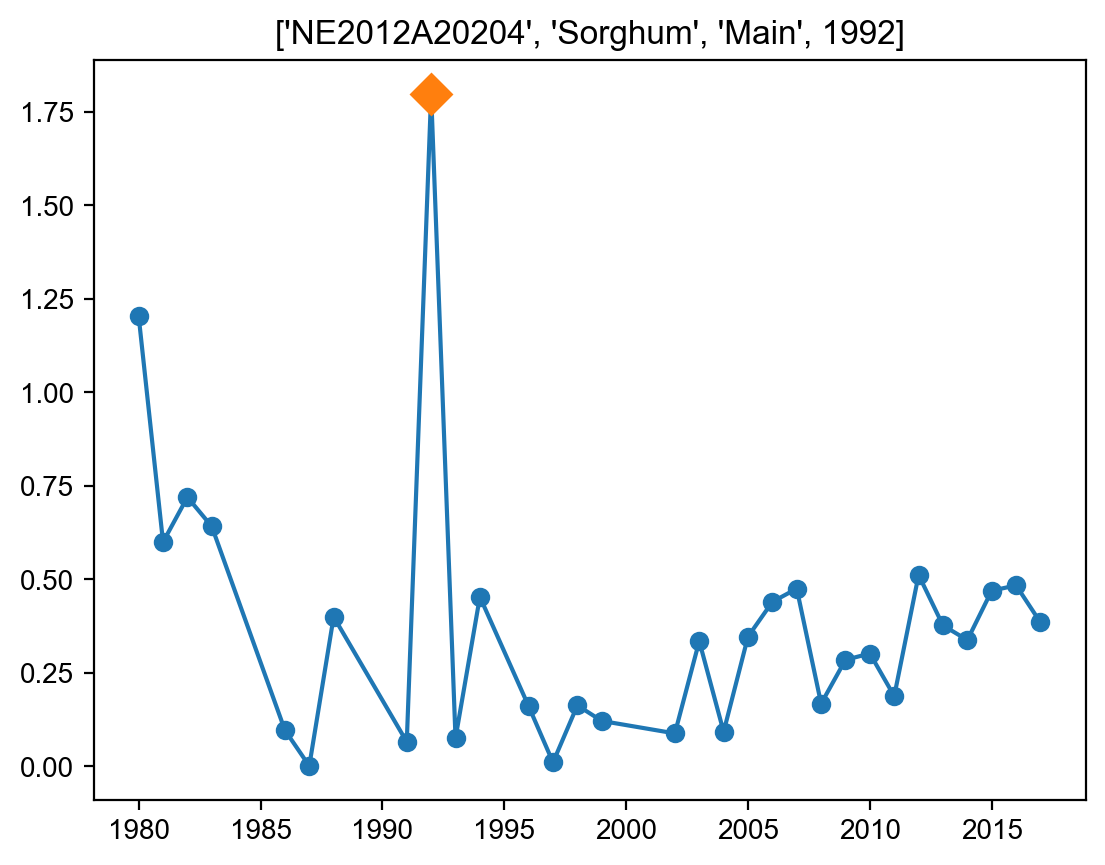

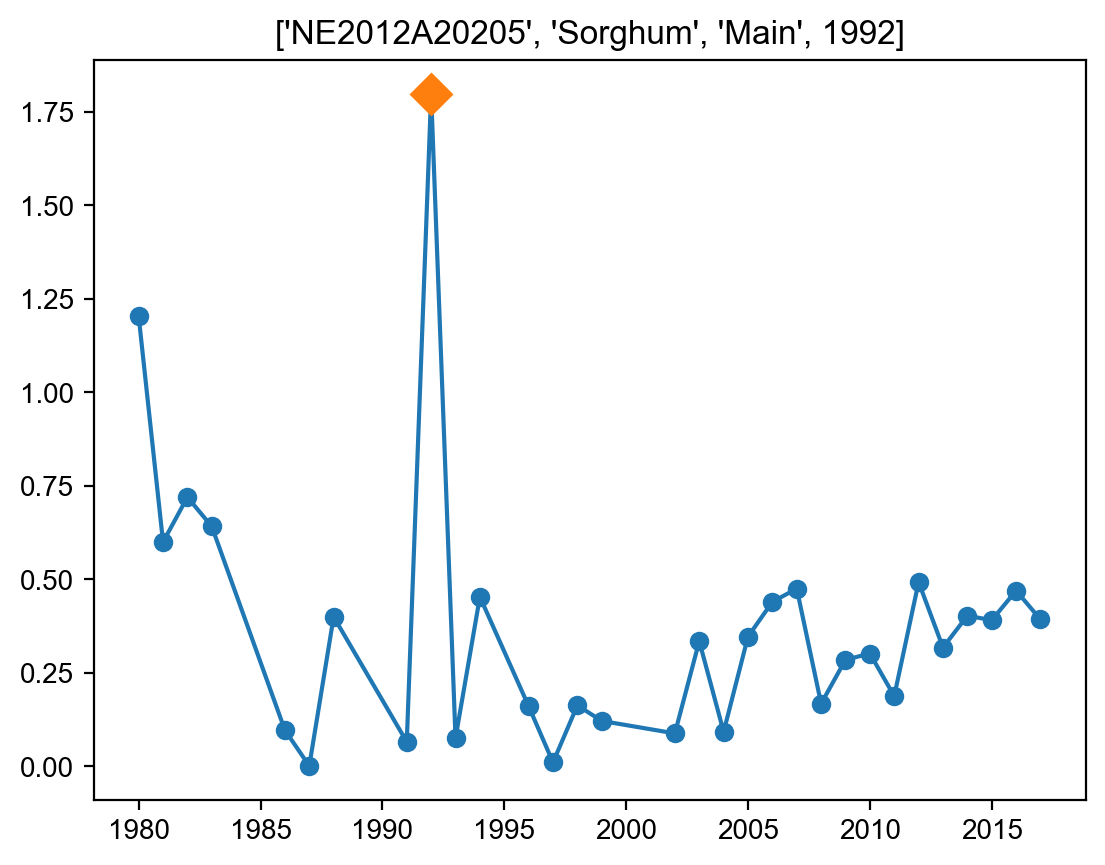

In [7]:
from matplotlib import pyplot as plt

outliers = [
            #['NE2012A20804','Millet','Main',2019],
            #['NE2012A20805','Millet','Main',2019],
            ['NE2012A20204','Sorghum','Main',1992],
            ['NE2012A20205','Sorghum','Main',1992],
            #['NE2012A20210','Sorghum','Main',1992],
            #['NE2012A20619','Sorghum','Main',2014],
            #['NE2012A20511','Groundnuts','Main',1996],
            #['NE2012A20510','Groundnuts','Main',1996],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
   

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_NE.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_NE_ratio.npz', link_ratio)

../data/crop/adm_crop_production_NE.csv is saved.
../data/crop/adm_crop_production_NE_ratio.npz is saved.


## Visualization of production data

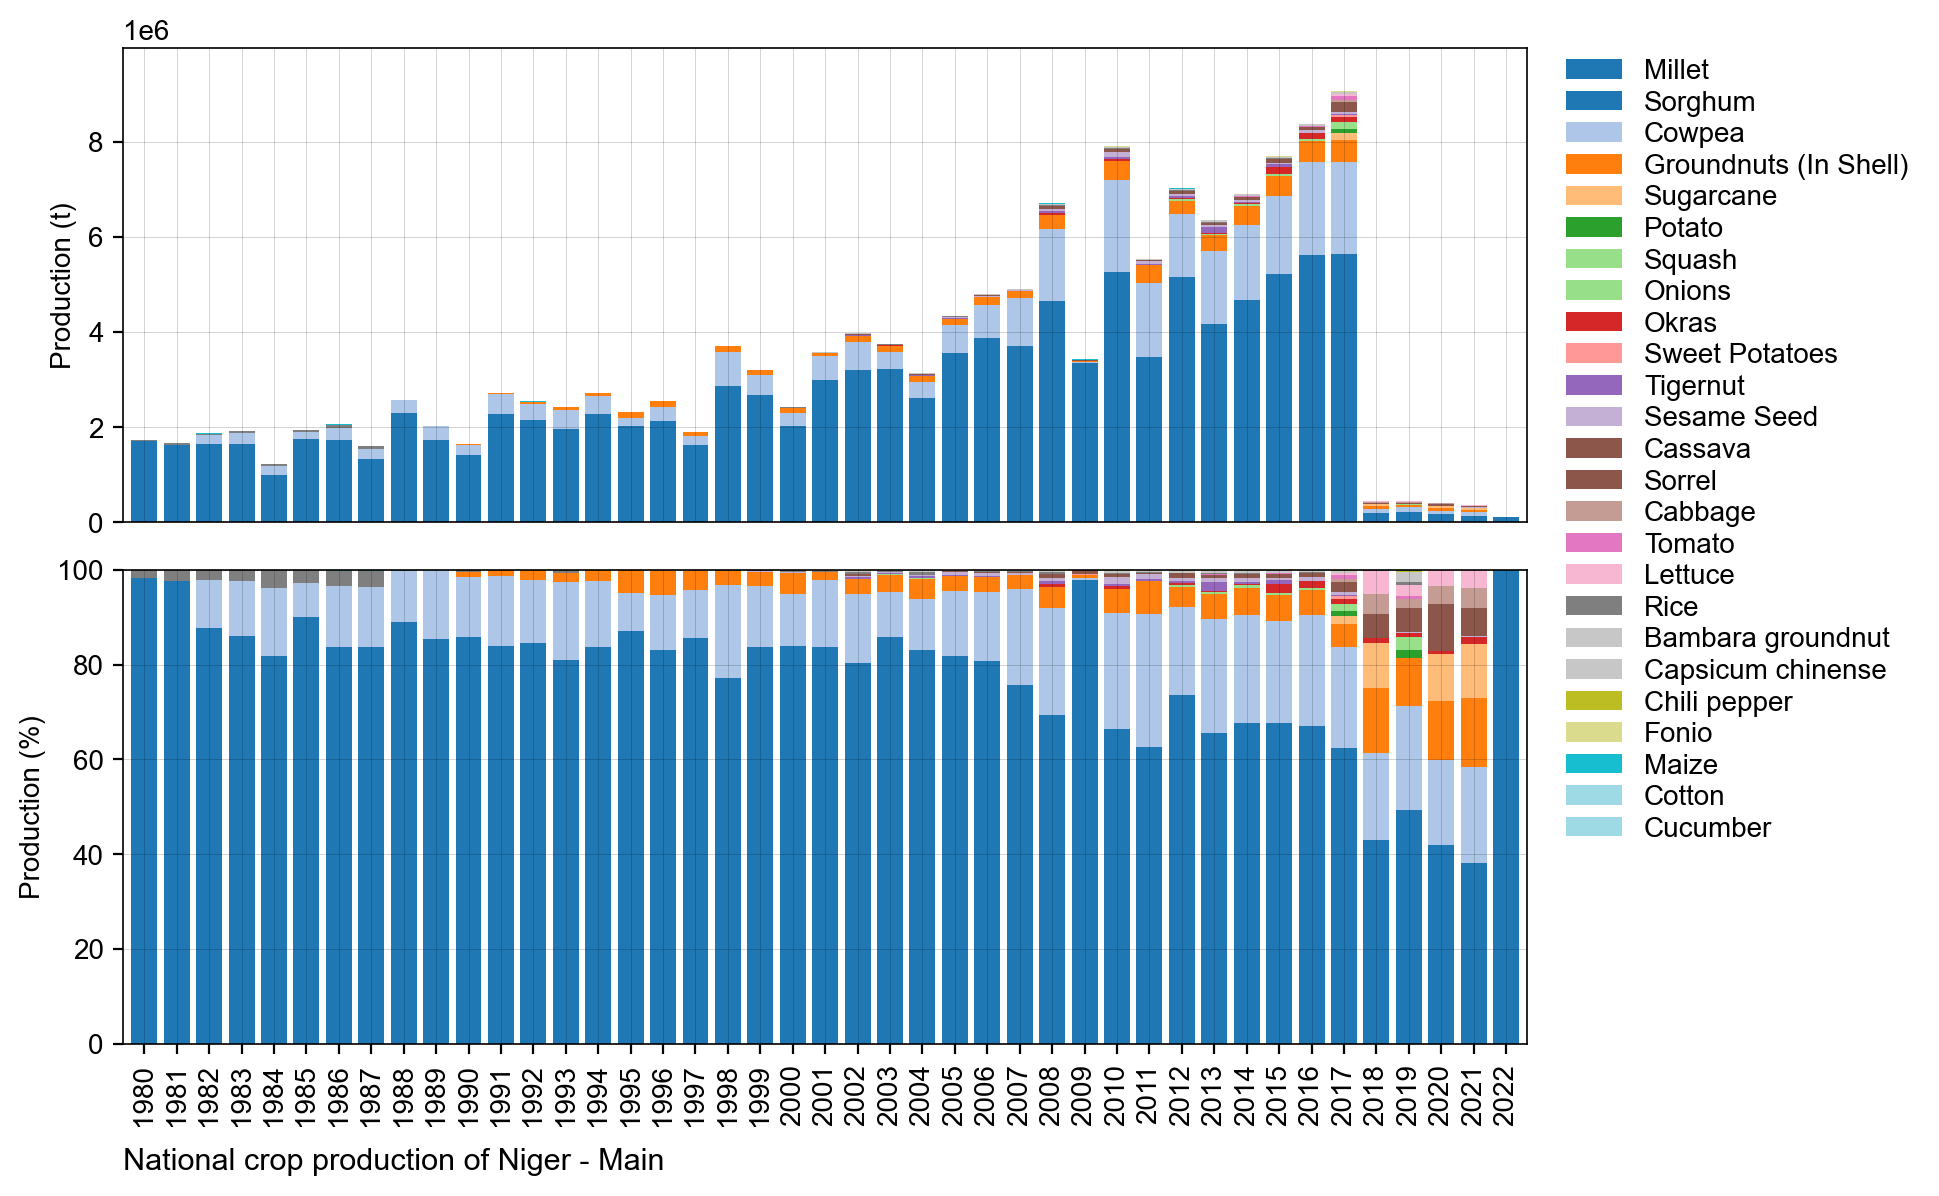

../figures/NE_bar_natgrainprod_Main.png is saved.


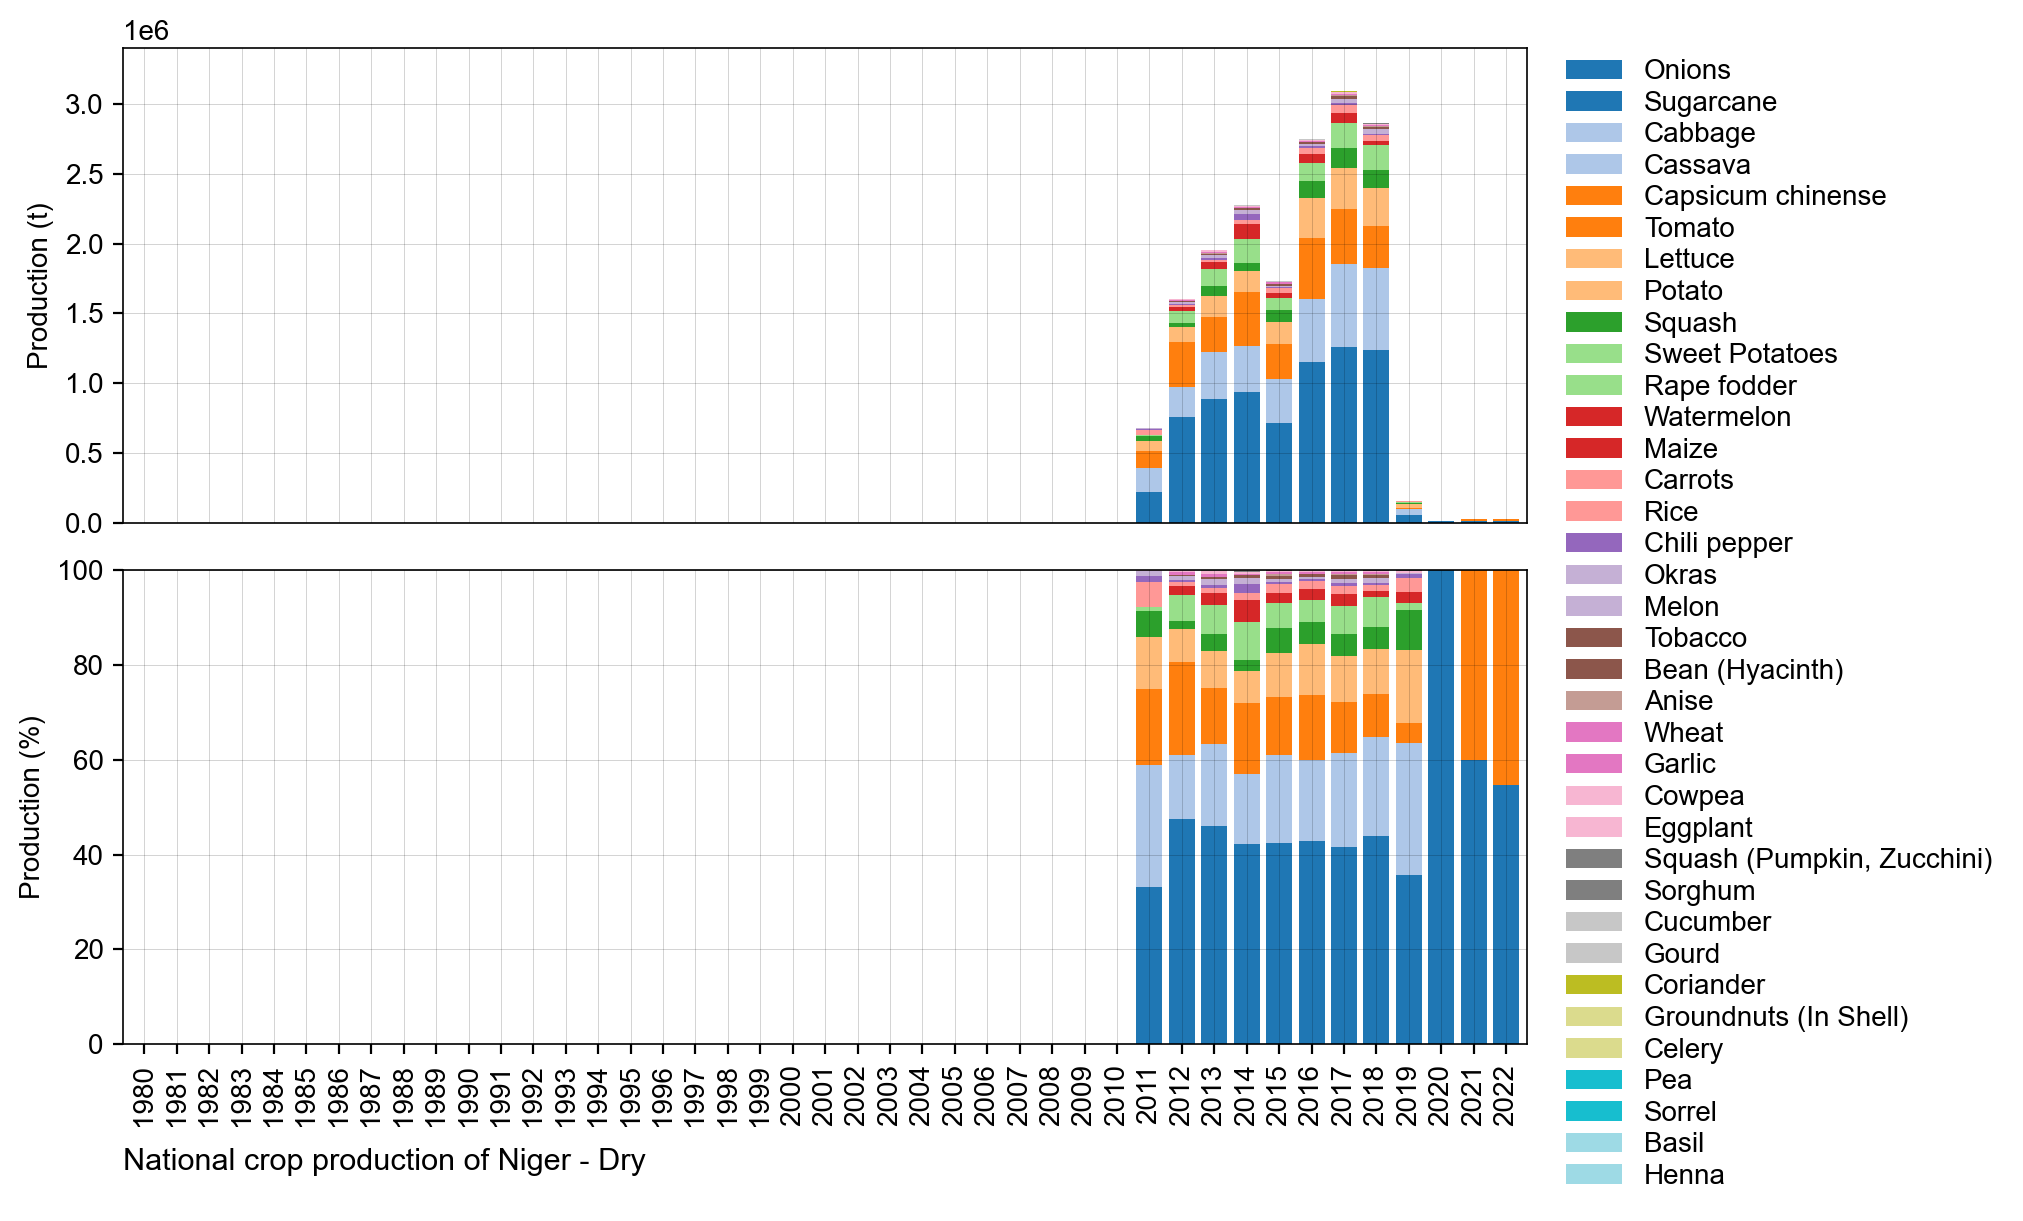

../figures/NE_bar_natgrainprod_Dry.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'NE', 'Niger'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main', 'Dry']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

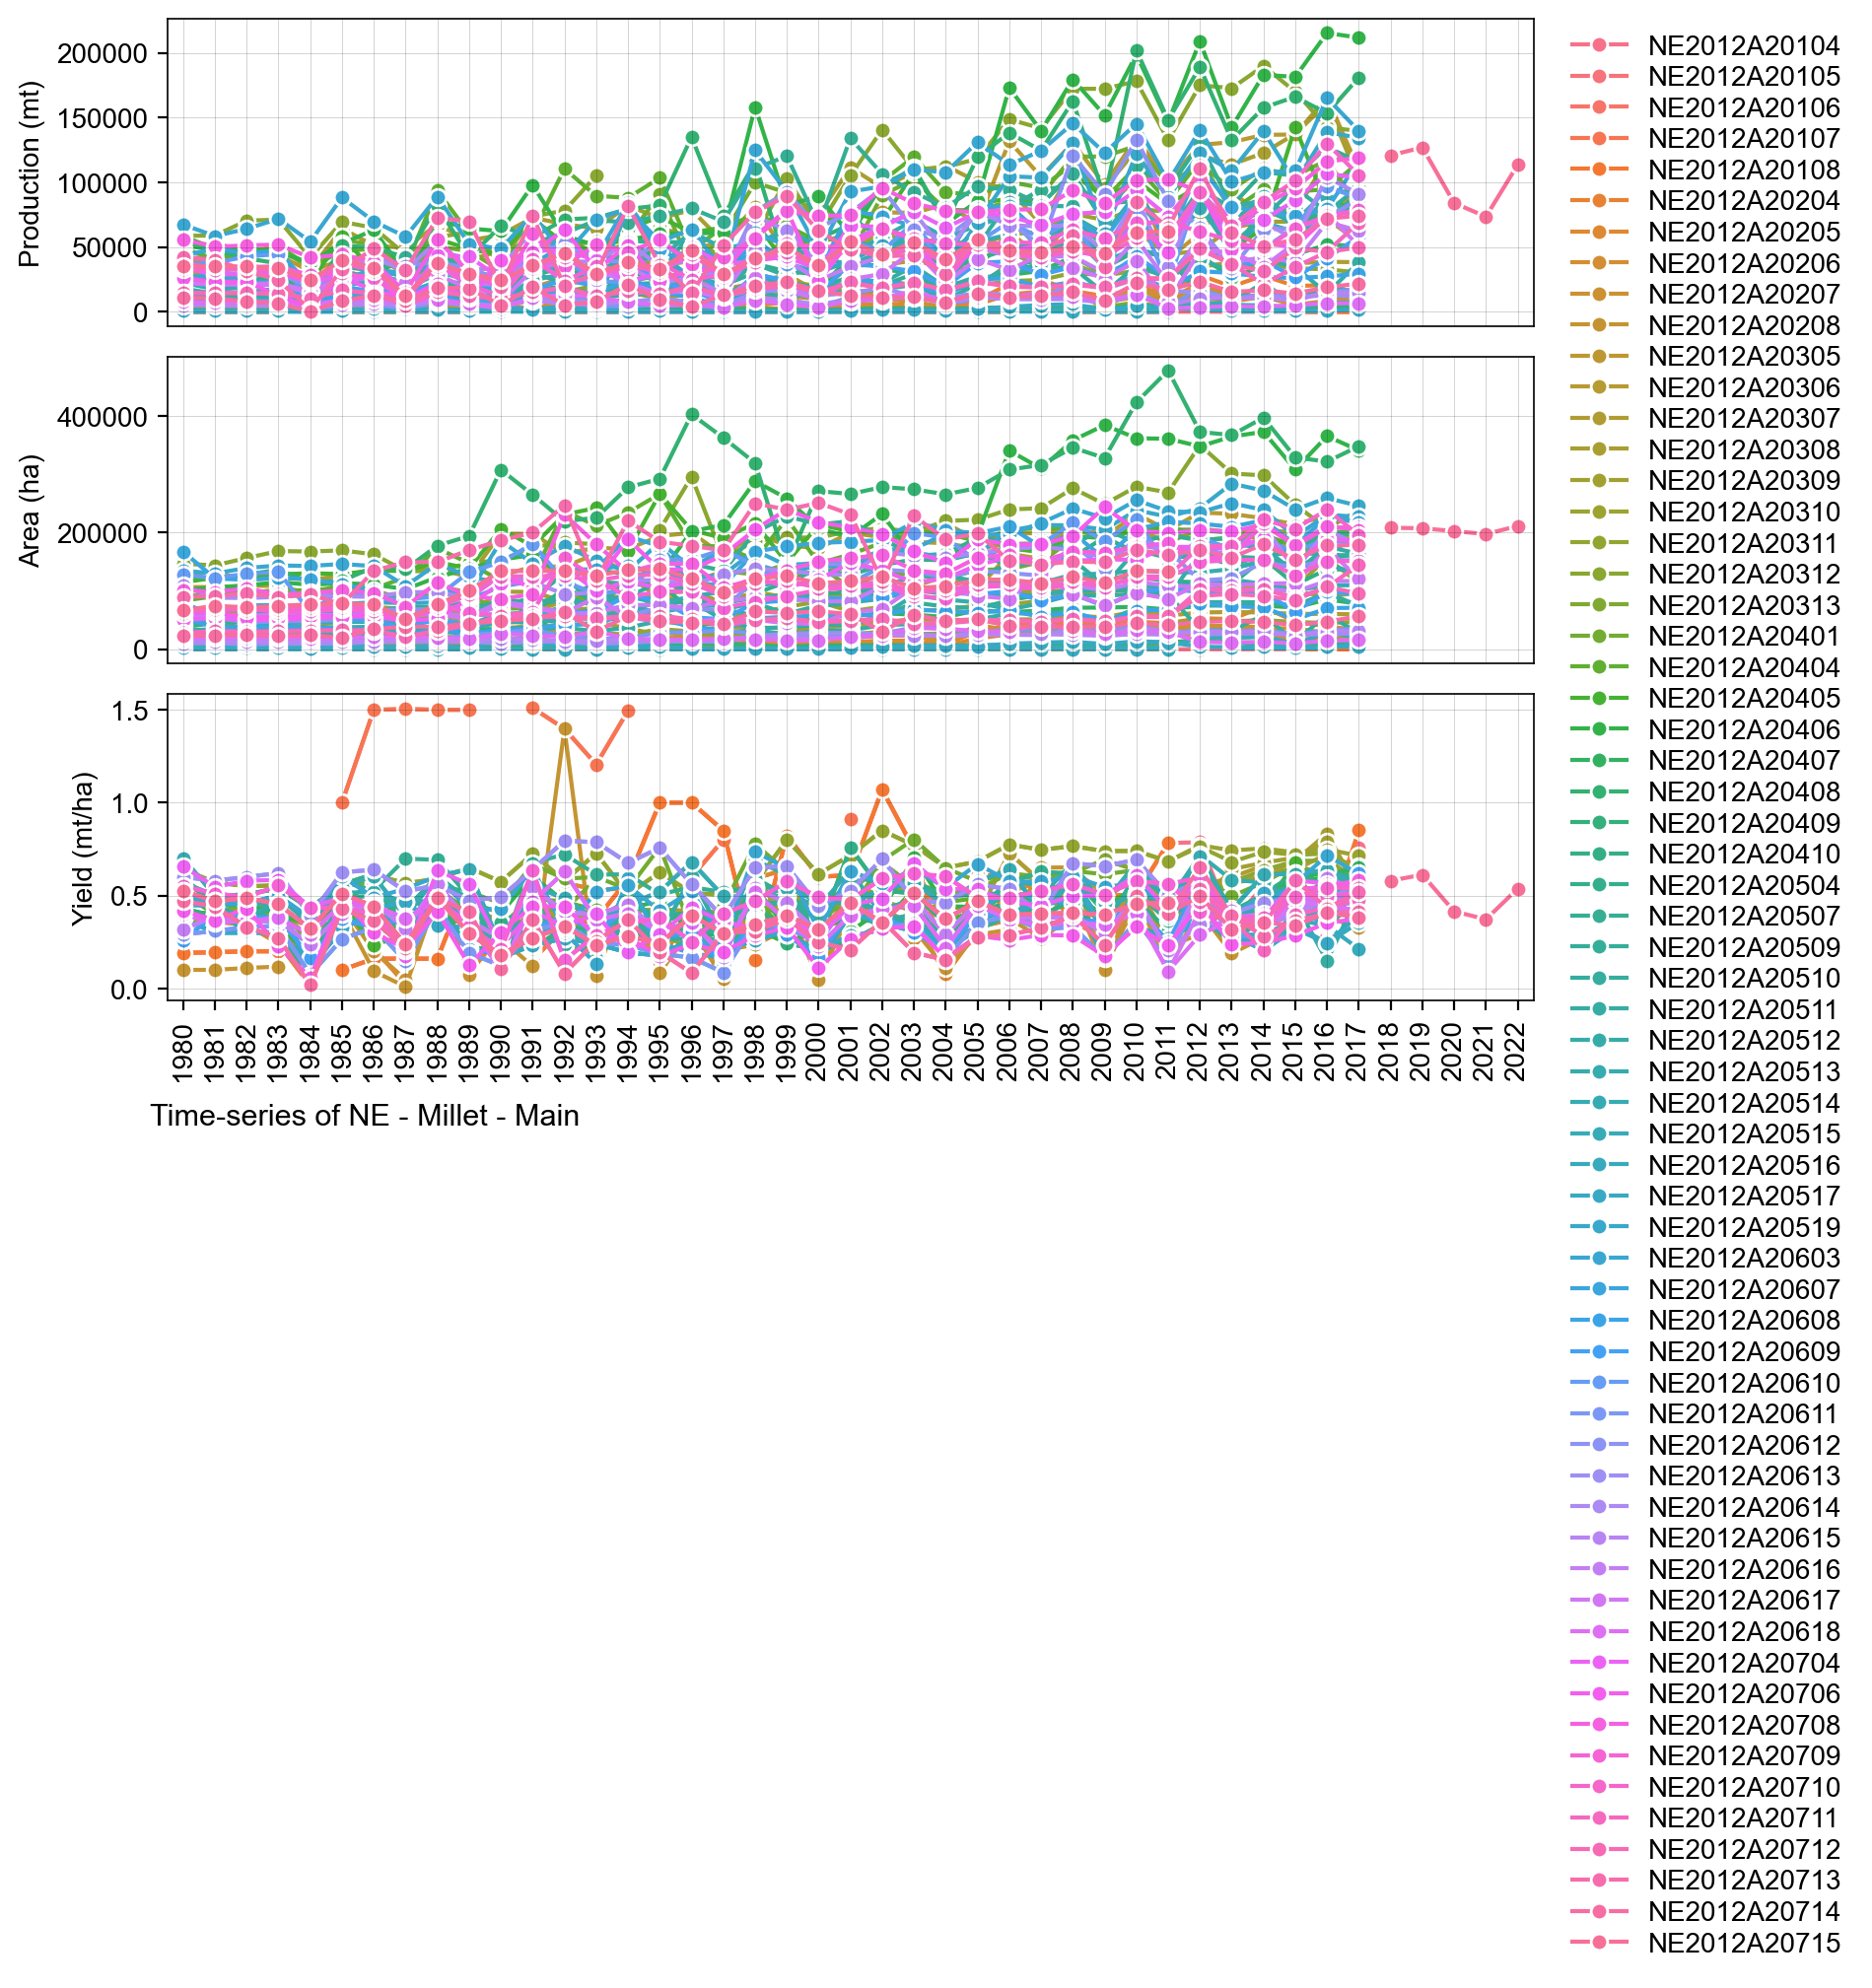

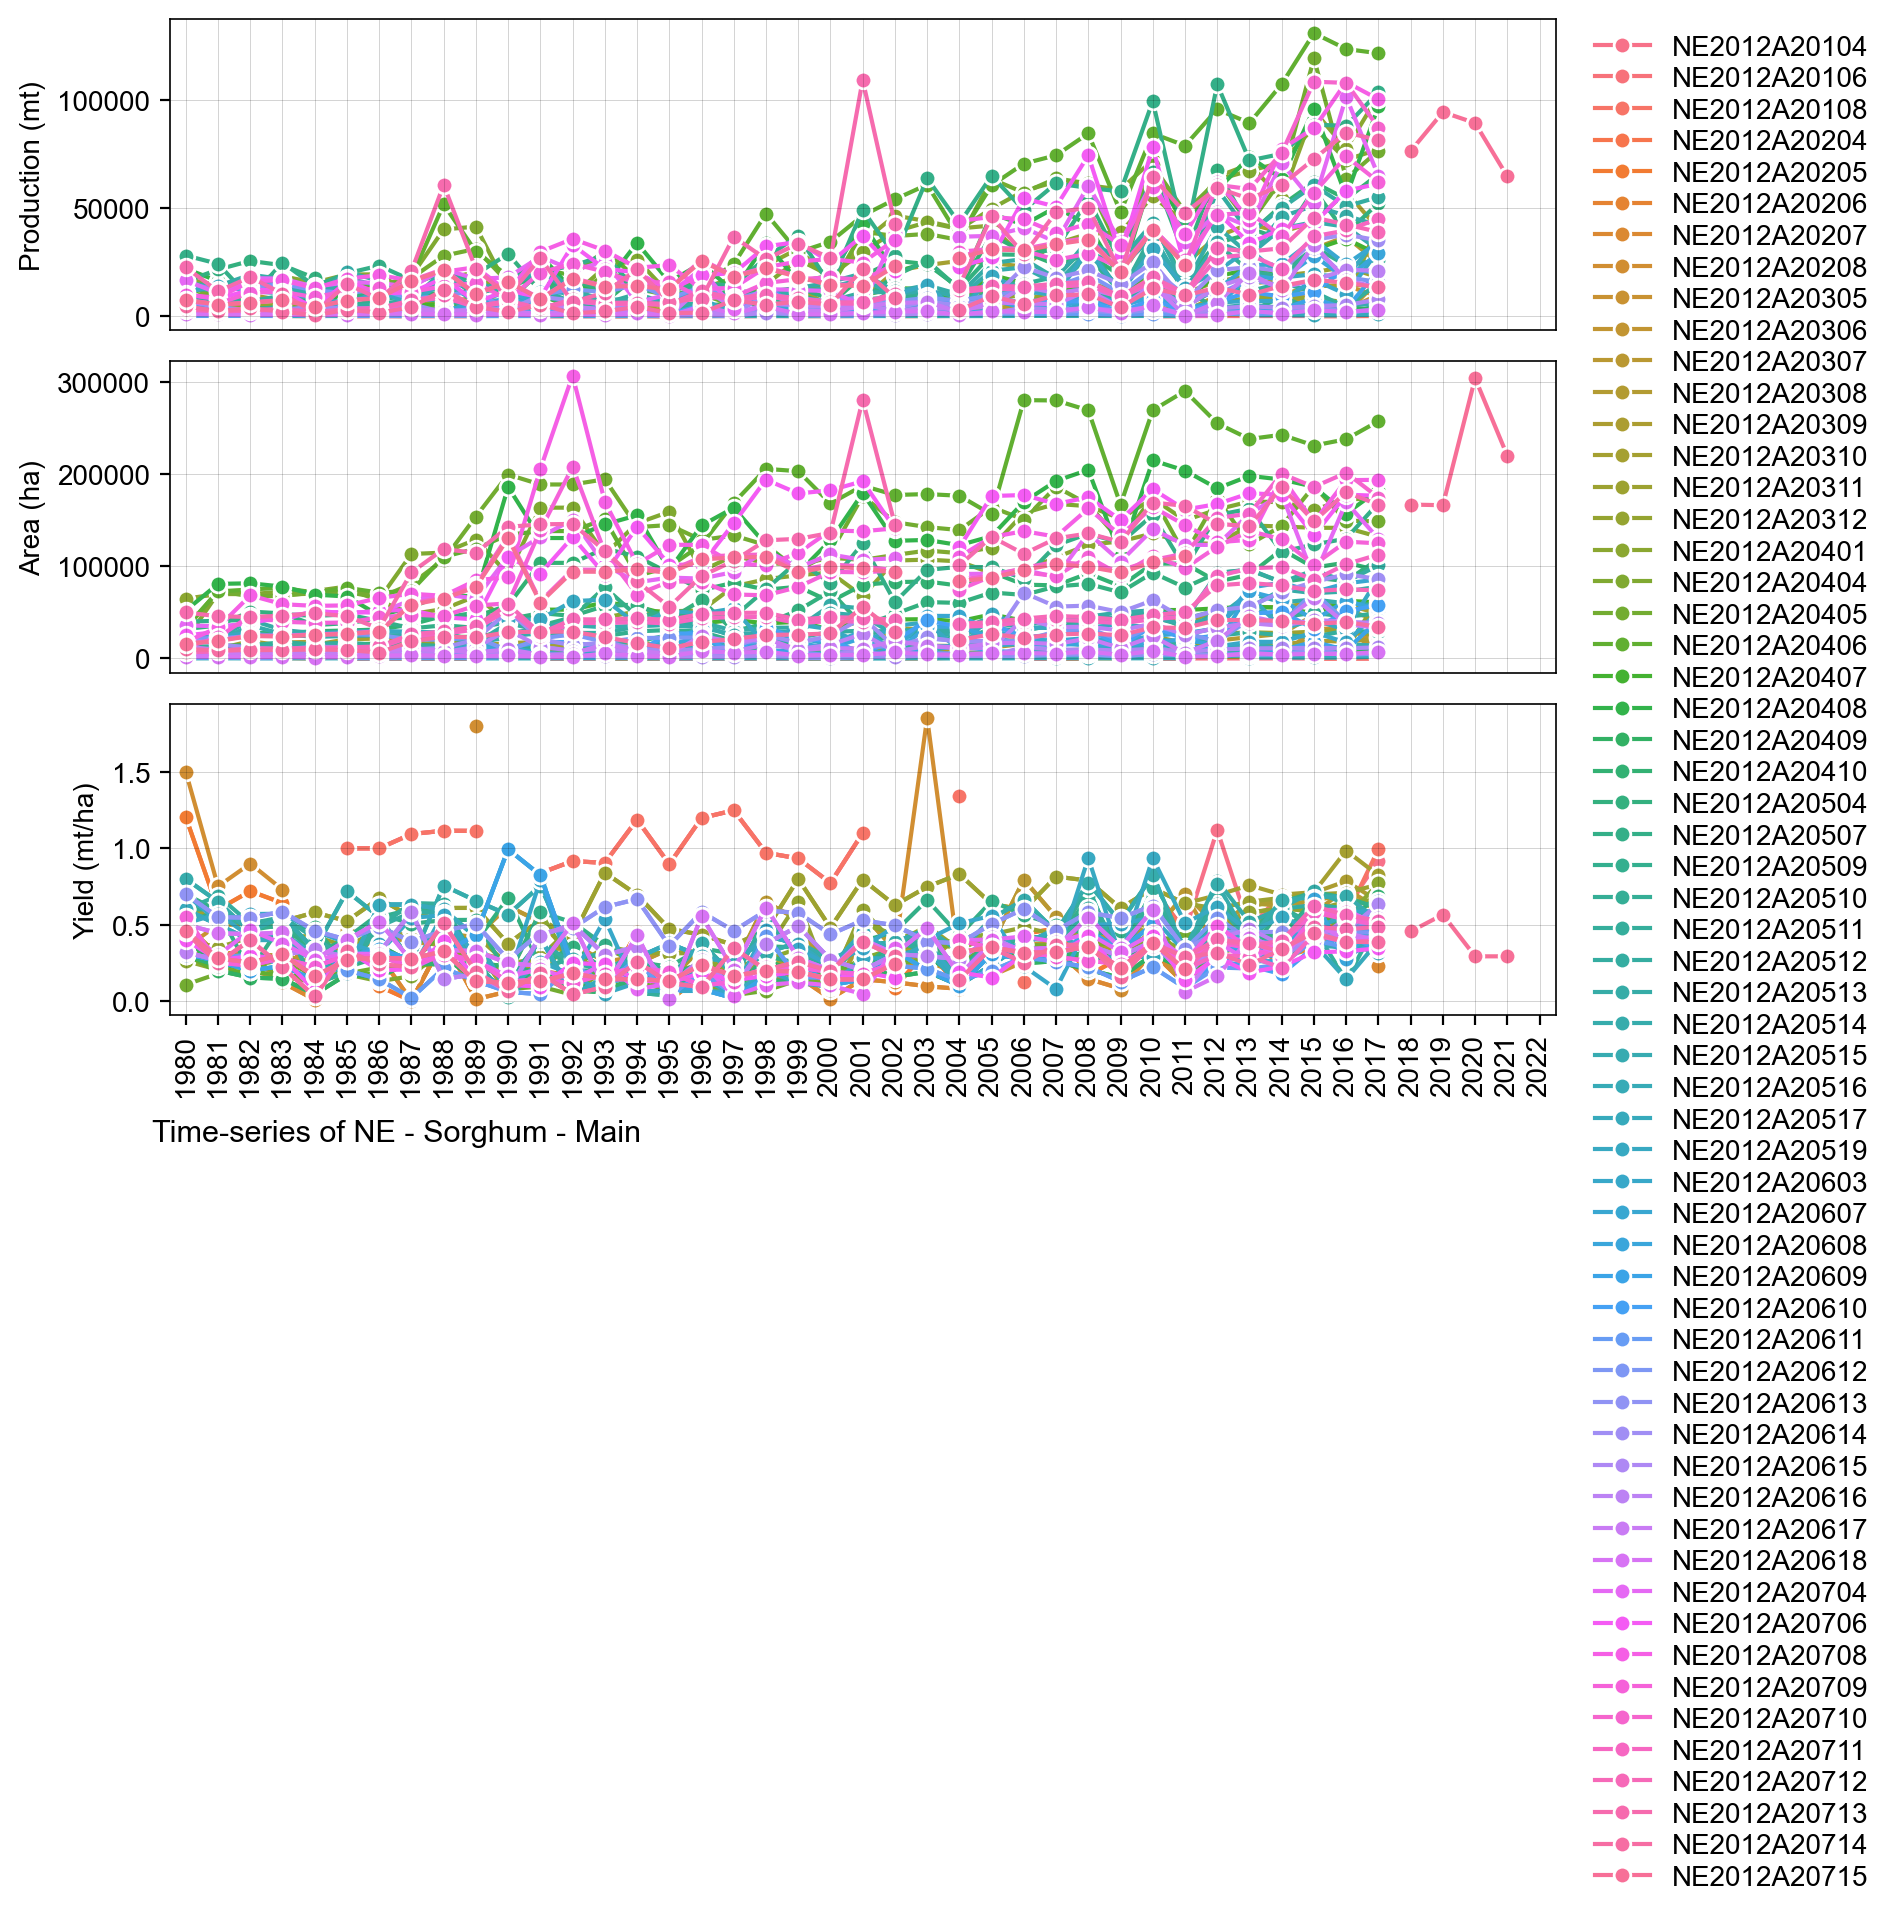

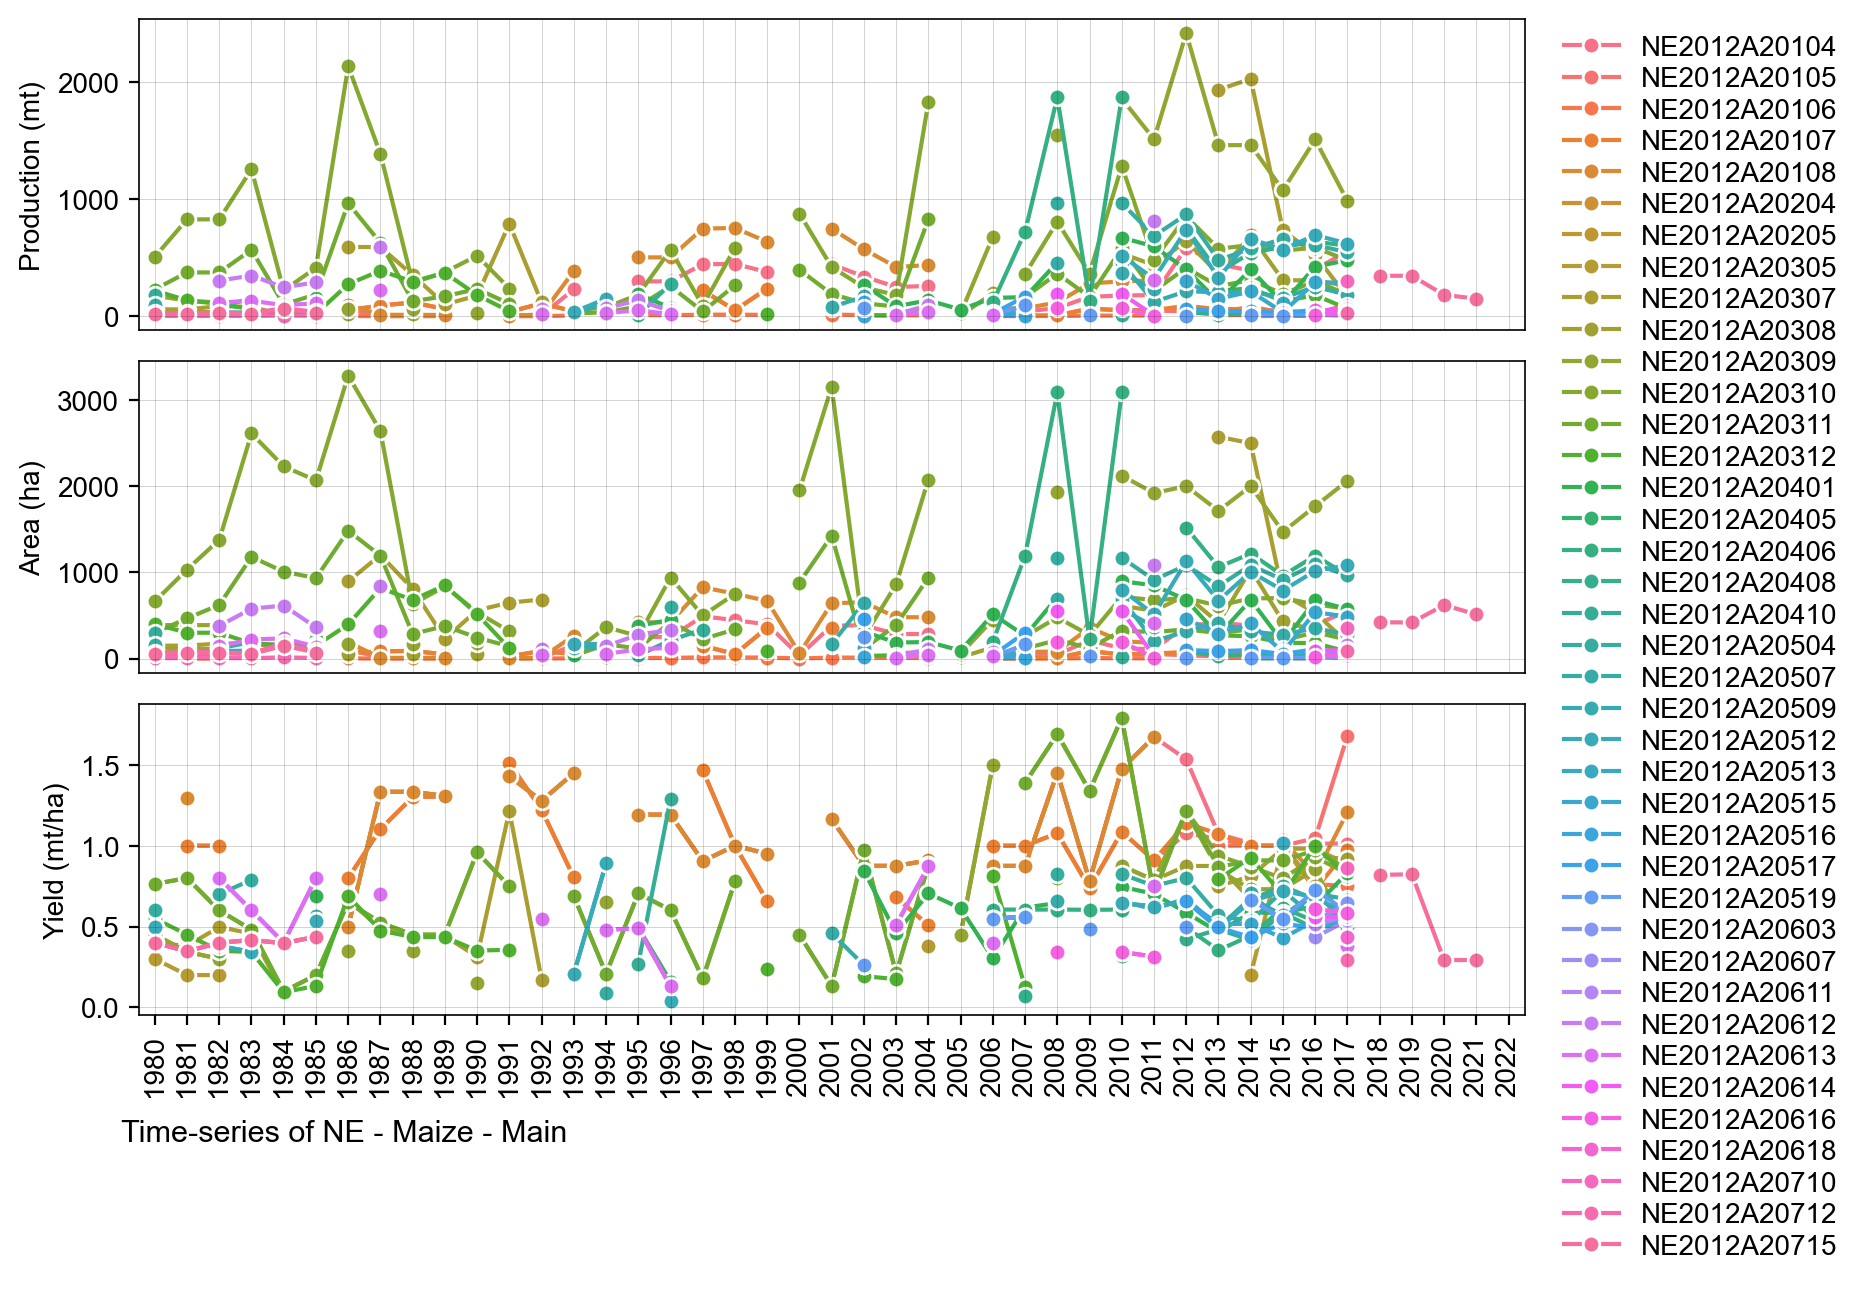

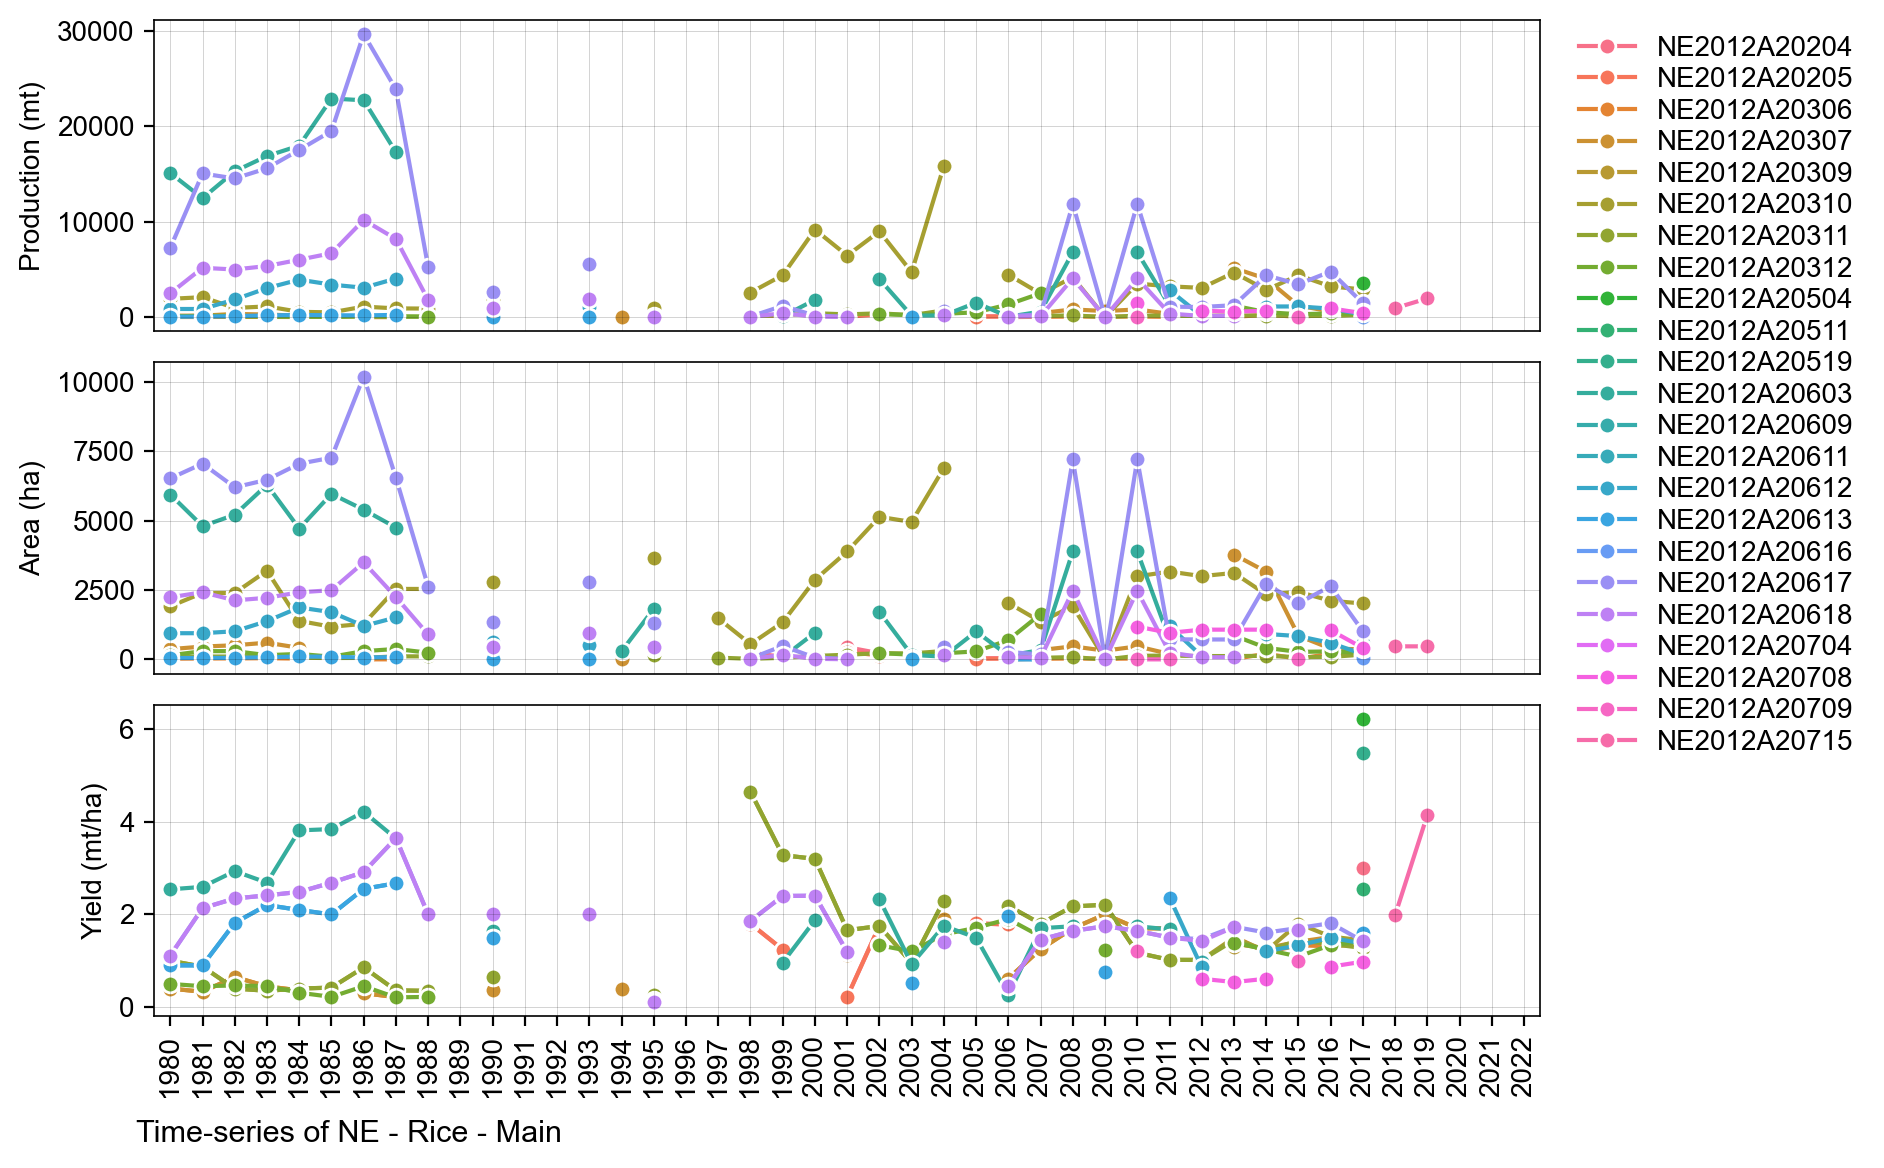

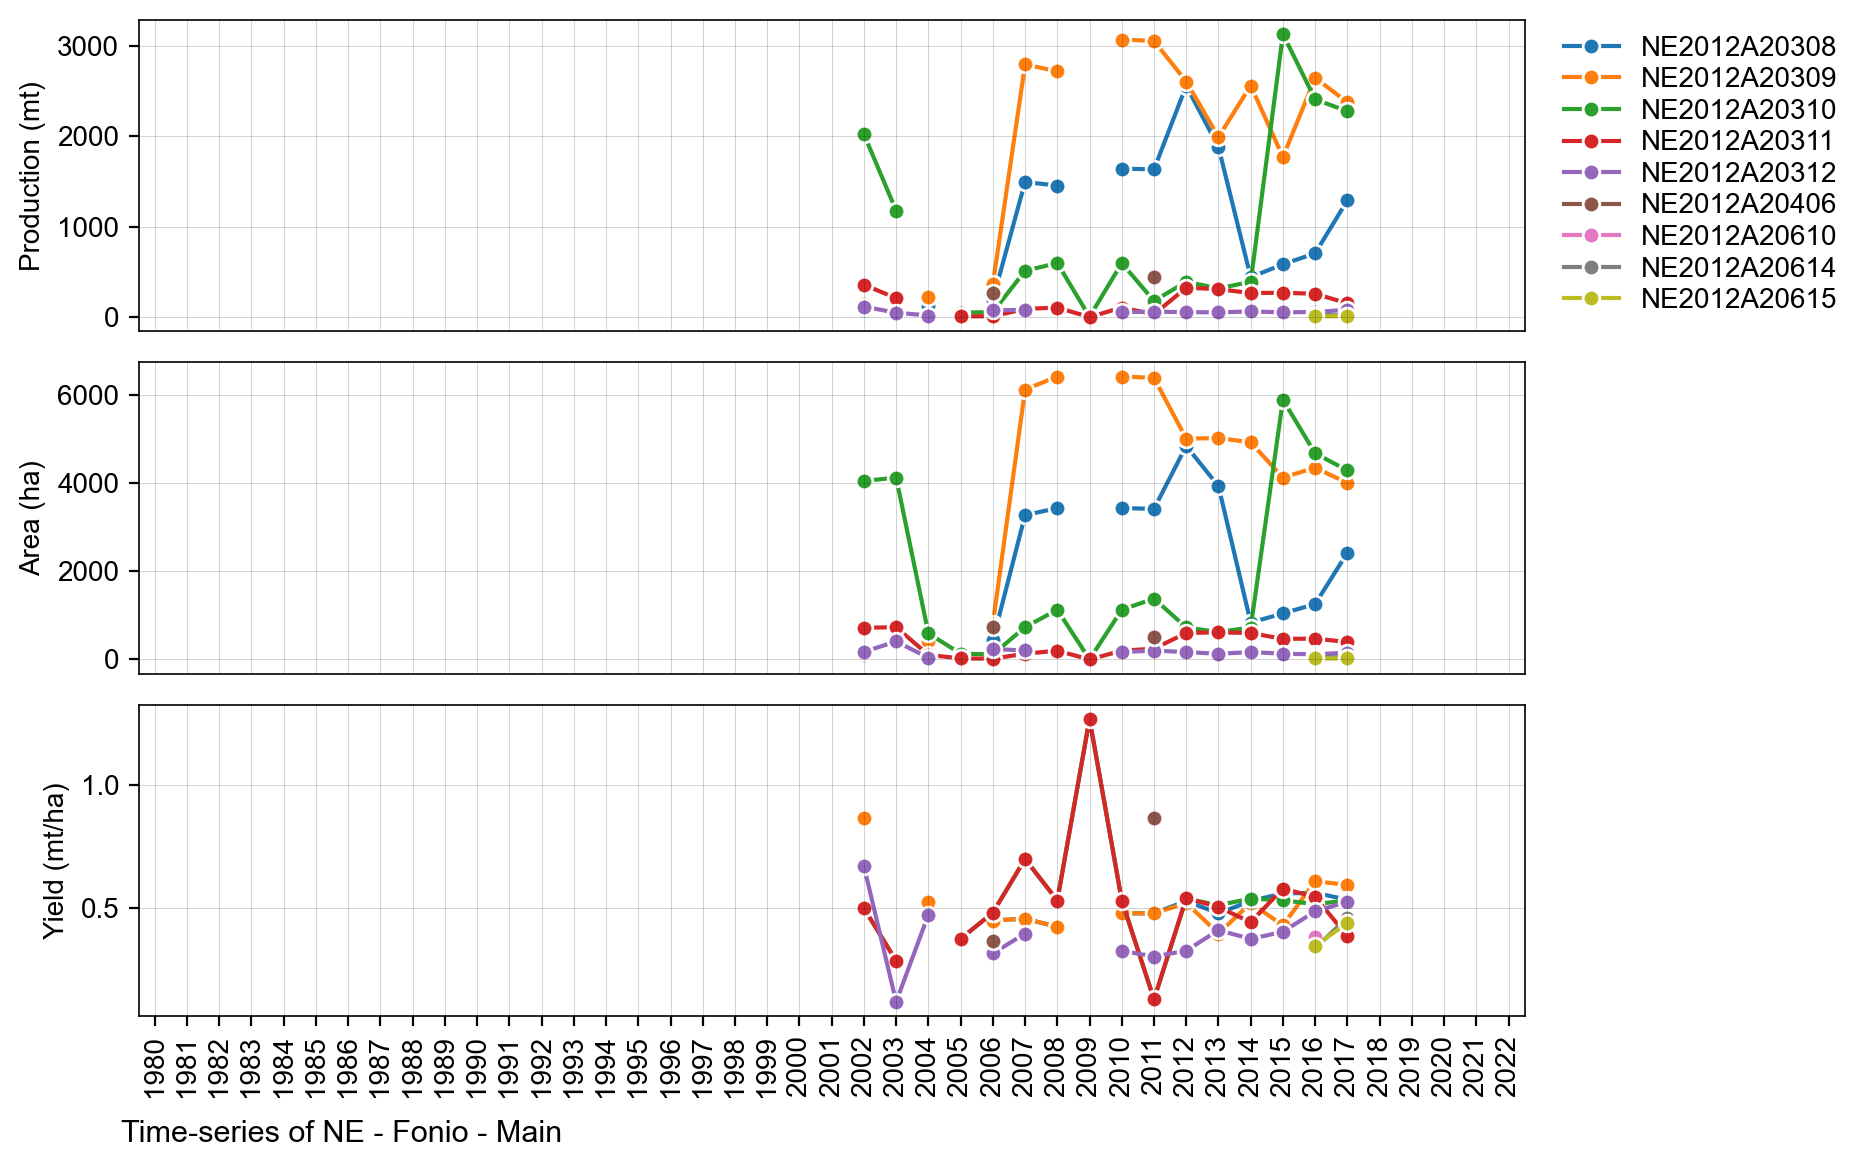

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'NE', 'Niger'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Main'],
    ['Sorghum','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
    ['Fonio','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)